# Pregunta 1

Se pide la construcción de un sistema de distribución de aguas, minimizando los costos de estas. Para esto, se tienen los siguientes datos:

|Datos|Valor|Dimensiones|
|:-:|:-:|:-:|
|Distancia cliente 1-planta 1|123.63|km|
|Distancia cliente 1-planta 2|287.06|km|
|Distancia cliente 2-planta 1|148.84|km|
|Distancia cliente 2-planta 2|371.35|km|
|Distancia planta 1-fuente 1|64.30|km|
|Distancia planta 1-fuente 2|272.97|km|
|Distancia planta 1-fuente 3|401.66|km|
|Distancia planta 2-fuente 1|352.52|km|
|Distancia planta 2-fuente 2|114.13|km|
|Distancia planta 2-fuente 3|192.11|km|
|Costo distancia|15|(\$/km*año)|
|Costo flujo|20|(\$/L)|
|Costo planta 1|350000|(\$/año)|
|Costo planta 2|300000|(\$/año)|
|Demanda cliente 1|300000|(L/año)|
|Demanda cliente 2|550000|(L/año)|

## Modelamiento:

### Superestructura:

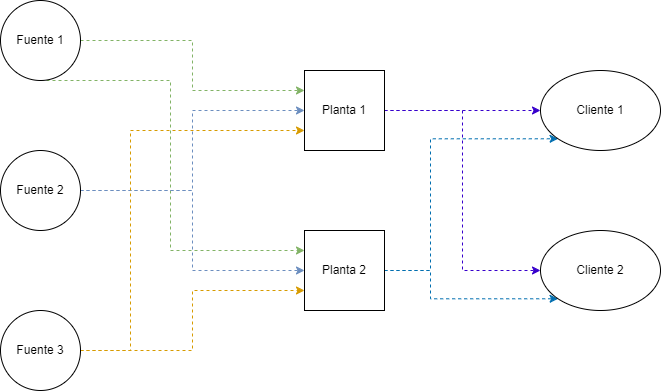

### Conjuntos:

* Fuentes: $F=[1,2,3]$
* Plantas: $P=[1,2]$
* Clientes: $C=[1,2]$

### Parámetros:

* Distancia fuente-planta: $Dist_{fp}(i,j) \quad; \forall i \in F; \forall j \in P$ (km)
* Distancia planta-cliente: $Dist_{pc}(j,l) \quad; \forall j \in P; \forall l \in C$ (km)
* Costo por distancia: $C_{d}$ (\$/km)
* Costo flujo: $C_{f}$ (\$/L)
* Costo anual por instalación de planta j: $C_{p}(j) \quad; \forall j \in P$
* Demanda cliente: $D_{l} \quad; \forall l \in C$ (L)

### Variables:

* Flujos de fuente i a planta j: $F_{fp}(i,j) \in \mathbb{R}^{+} \quad; \forall i \in F; \forall j \in P$ (L/año)
* Flujos de planta j a cliente l: $F_{pc}(j,l) \in \mathbb{R}^{+} \quad; \forall j \in P; \forall l \in C$ (L/año)
* Existencia de planta j: $S(j) \quad; \forall j \in P$ (bool)
* Existencia flujo de fuente i a planta j: $Sfp(i,j) \quad; \forall i \in F; \forall j \in P$ (bool)
* Existencia flujo de planta j a cliente l: $Spc(j,l) \quad; \forall j \in P; \forall l \in C$ (bool)

### Restricciones:

* Balance de masa (Todo lo que entra en la planta debe salir):

$$\sum_{i \in F} F_{fp}(i,j) = \sum_{l \in L} F_{pc}(j,l) \quad \forall j \in P$$

* Coherencia entre flujos y existencias:

$$Sfp(i,j) \cdot M \geq F_{fp}(i,j) \quad \forall i \in F; \forall j \in P$$
$$Spc(j,l) \cdot M \geq F_{pc}(j,l) \quad \forall j \in P; \forall l \in L$$

* Coherencia entre existencias:

$$S(j) \cdot |F| \geq \sum_{i \in F} Sfp(i,j) \quad \forall j \in P$$
$$S(j) \cdot |C| \geq \sum_{l \in L} Spc(j,l) \quad \forall j \in P$$

* Demanda: Para este caso, la restricción es que la suma de los flujos es mayor o igual a la demanda, debido a que, si es menor, o igual, los flujos serán cero, ya que se está minimizando los costos.

$$\sum_{j \in P} F_{pc}(j,l) \geq D(l) \quad \forall l \in C$$

### Función Objetivo:

$$Min: C_{f}\sum_{j \in P} \left ( \sum_{i \in F} F_{fp}(i,j) + \sum_{l \in C} F_{pc}(j,l) \right ) + \sum_{j \in P} S(j) \cdot C_{p}(j) + C_{d} \sum_{j \in P} \left( \sum_{i \in F} Dist_{fp}(i,j) \cdot Sfp(i,j) + \sum_{l \in C} Dist_{pc}(j,l) \cdot Spc(j,l) \right )$$ 

In [3]:
using JuMP, Cbc

P1 = Model(Cbc.Optimizer)
#------------------------Conjuntos----------------------------------------#

F = [1,2,3]
P = [1,2]
C = [1,2]

#-----------------------Parámetros----------------------------------------#

# Costo por distancia

Cd = 15 #($/km*año)

# Costo flujo 

Cf = 20 #($/L)

# Costo por planta
Cp = Dict() #($/año)

Cp[(1)] = 350000
Cp[(2)] = 300000

# Demanda cliente
D = Dict() #(L/año)

D[(1)] = 300000
D[(2)] = 550000

# Distancias:
    
    # Distancia fuente-planta:
    Distfp = Dict() #(km)
    
    # Planta 1
    Distfp[(1,1)] = 64.30
    Distfp[(2,1)] = 272.97
    Distfp[(3,1)] = 401.66
    
    # Planta 2
    Distfp[(1,2)] = 352.52
    Distfp[(2,2)] = 114.13
    Distfp[(3,2)] = 192.11

    # Distancia planta-cliente:
    Distpc = Dict() #(km)

    # Cliente 1
    Distpc[(1,1)] = 123.63
    Distpc[(2,1)] = 287.06

    # Cliente 2
    Distpc[(1,2)] = 148.84
    Distpc[(2,2)] = 371.35

# Big M
M = 1e6

#----------------------------------Variables-------------------------------------#

#Flujo de fuente i a planta j
@variable(P1, Ffp[i in F, j in P]>=0)

#Flujo de planta j a cliente l
@variable(P1, Fpc[j in P, l in C]>=0)

#Existencia de planta j
@variable(P1, S[j in P], Bin)

#Existencia de flujo de fuente i a planta j
@variable(P1, Sfp[i in F, j in P], Bin)

#Existencia de flujo de planta j a cliente l
@variable(P1, Spc[j in P, l in C], Bin)

#----------------------------------Restricciones----------------------------------#

# Balance de masa 

for j in P
    @constraint(P1, sum(Ffp[i,j] for i in F) == sum(Fpc[j,l] for l in C))
end

# Coherencia entre flujos y existencias

for j in P
    for i in F
        @constraint(P1, M*Sfp[i,j] >= Ffp[i,j]) # fuente-planta
    end
end

for j in P
    for l in C
        @constraint(P1, M*Spc[j,l] >= Fpc[j,l]) # planta-cliente
    end
end

# Coherencia entre existencias

for j in P
    @constraint(P1, length(F)*S[j] >= sum(Sfp[i,j] for i in F))
    @constraint(P1, length(C)*S[j] >= sum(Spc[j,l] for l in C))
end

# Demanda 
for l in C
    @constraint(P1, sum(Fpc[j,l] for j in P) >= D[l])
end

#---------------------------------------Función objetivo--------------------------------------#

@expression(P1, costo1, Cf*sum((sum(Ffp[i,j] for i in F)+sum(Fpc[j,l] for l in C)) for j in P))
@expression(P1, costo2, sum(S[j]*Cp[j] for j in P))
@expression(P1, costo3, Cd*sum(sum(Distfp[i,j]*Sfp[i,j] for i in F)+sum(Distpc[j,l]*Spc[j,l] for l in C) for j in P))
@objective(P1, Min, costo1+costo2+costo3)
optimize!(P1)

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 3.41333e+07 - 0.00 seconds
Cgl0004I processed model has 18 rows, 22 columns (12 integer (12 of which binary)) and 48 elements
Cbc0038I Initial state - 4 integers unsatisfied sum - 1.325
Cbc0038I Pass   1: suminf.    0.65000 (2) obj. 3.42036e+07 iterations 4
Cbc0038I Pass   2: suminf.    0.30000 (1) obj. 3.43086e+07 iterations 1
Cbc0038I Solution found of 3.43116e+07
Cbc0038I Relaxing continuous gives 3.43116e+07
Cbc0038I Before mini branch and bound, 8 integers at bound fixed and 7 continuous
Cbc0038I Full problem 18 rows 22 columns, reduced to 0 rows 0 columns
Cbc0038I Mini branch and bound did not improve solution (0.00 seconds)
Cbc0038I Round again with cutoff of 3.42938e+07
Cbc0038I Pass   3: suminf.    0.65000 (2) obj. 3.42036e+07 iterations 0
Cbc0038I Pass   4: suminf.    0.34938 (2) obj. 3.42938e+07 iterations 1

In [4]:
for j in P
    if value.(S[j])==1
        println("La planta ", j, " debe ser instalada")
        println(" ")
        for i in F
            if value.(Sfp[i,j])==1
                println("La planta necesita recibir ", value.(Ffp[i,j]), " (L/año) de la fuente ", i,".")
                println(" ")
            end
        end
        for l in C
            if value.(Spc[j,l])==1
                println("La planta suministrará ", value.(Fpc[j,l]), " (L/año) al cliente ", l, ".")
                println(" ")
            end
        end
    else
        println("La planta ", j, " no debe ser instalada")
        println(" ")
    end
end

println("Para esta configuración los costos mínimos que se obtuvieron fueron: ", objective_value(P1), " (\$/año).")
println(" ")
println("Finalmente, la solución es la siguiente:")

La planta 1 no debe ser instalada
 
La planta 2 debe ser instalada
 
La planta necesita recibir 850000.0 (L/año) de la fuente 2.
 
La planta suministrará 300000.0 (L/año) al cliente 1.
 
La planta suministrará 550000.0 (L/año) al cliente 2.
 
Para esta configuración los costos mínimos que se obtuvieron fueron: 3.43115881e7 ($/año).
 
Finalmente, la solución es la siguiente:


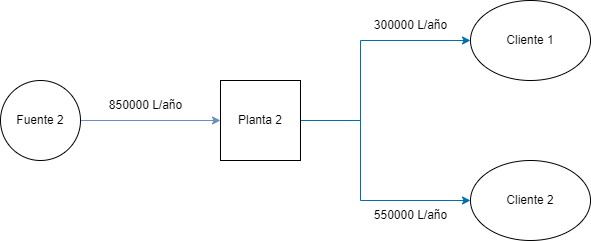